In [41]:
import pandas as pd
import numpy as np

import os
import pickle
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix, accuracy_score

from keras.preprocessing.text import Tokenizer

from keras.layers import Embedding, Flatten, Dense, SimpleRNN, LSTM
from keras.models import Sequential

from keras import preprocessing

import matplotlib.pyplot as plt 


from tensorflow.keras.callbacks import EarlyStopping

# Data Preprocessing
Import the IMBD data set, skipping the most common words

In [103]:
# References:
# https://machinelearningmastery.com/deep-learning-bag-of-words-model-sentiment-analysis/
# hhttps://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/6.1-using-word-embeddings.ipynb

def preprocess_review(filename):
    # open the review
    review = open(filename, 'r')
    text = review.read()
    review.close()
    
    # remove line break tags
    text = text.replace('<br />', ' ')

    # remove tokens that are not alphabetic
    tokens = text.split()

    # filter out stop words with nltk
    stop_words = set(stopwords.words('english'))
    tokens = [w.lower() for w in tokens if not w in stop_words]
    tokens = [w for w in tokens if len(w)>1]
    
    return ' '.join(tokens)


def preprocess_directory(directory):
    # Create the list of reviews
    text = []

    for filename in os.listdir(directory):
        if filename.endswith('.txt'):
            src = os.getcwd() + '/' + directory + '/' + filename

            # Preprocess the review and append it to the list
            text.append(preprocess_review(src))

    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/voldemort/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [104]:
imdb_train_neg = preprocess_directory(os.path.join('aclImdb/train/neg'))
pickle.dump(imdb_train_neg, open('imdb_train_neg.pkl', 'wb'))

In [106]:
imdb_train_pos = preprocess_directory(os.path.join('aclImdb/train/pos'))
pickle.dump(imdb_train_pos, open('imdb_train_pos.pkl', 'wb'))

imdb_train_neutral = preprocess_directory(os.path.join('aclImdb/train/unsup'))
pickle.dump(imdb_train_neutral, open('imdb_train_neutral.pkl', 'wb'))

imdb_test_pos = preprocess_directory(os.path.join('aclImdb/test/pos'))
pickle.dump(imdb_test_pos, open('imdb_test_pos.pkl', 'wb'))

imdb_test_neg = preprocess_directory(os.path.join('aclImdb/test/neg'))
pickle.dump(imdb_test_neg, open('imdb_test_neg.pkl', 'wb'))


In [2]:
imdb_train_pos = pickle.load(open('imdb_train_pos.pkl', 'rb'))
imdb_train_neg = pickle.load(open('imdb_train_neg.pkl', 'rb'))

imdb_test_pos = pickle.load(open('imdb_test_pos.pkl', 'rb'))
imdb_test_neg = pickle.load(open('imdb_test_neg.pkl', 'rb'))

In [3]:
train_labels_pos = [1] * len(imdb_train_pos)
train_labels_neg = [0] * len(imdb_train_pos)

train_data = imdb_train_pos + imdb_train_neg
train_labels = train_labels_pos + train_labels_neg

In [4]:
test_labels_pos = [1] * len(imdb_test_pos)
test_labels_neg = [0] * len(imdb_test_pos)

test_data = imdb_test_pos + imdb_test_neg
test_labels = test_labels_pos + test_labels_neg

In [5]:
train_df = pd.DataFrame({'Text': train_data, 'Sentiment': train_labels})
test_df = pd.DataFrame({'Text': test_data, 'Sentiment': test_labels})



In [6]:
train_df = train_df.sample(frac=1)
test_df = test_df.sample(frac=1)

In [7]:
train_data = np.asarray(train_df['Text'])
train_labels = np.asarray(train_df['Sentiment'])

test_data = np.asarray(test_df['Text'])
test_labels = np.asarray(test_df['Sentiment'])

## Keras Embeddings + MLP

In [126]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_data)
train_sequences = tokenizer.texts_to_sequences(train_data)
test_sequences = tokenizer.texts_to_sequences(test_data)

word_index = tokenizer.word_index
print('Found {} unique tokens'.format(len(word_index)))


Found 88065 unique tokens


In [128]:
maxlen=20
x_train = preprocessing.sequence.pad_sequences(train_sequences, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(test_sequences, maxlen=maxlen)


In [129]:
model = Sequential()
model.add(Embedding(10000, 8, input_length=maxlen))
model.add(Flatten())

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, train_labels,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_2 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 2s 104us/step - loss: 0.6540 - acc: 0.6576 - val_loss: 0.5770 - val_acc: 0.7424
Epoch 2/10
20000/20000 [==============================] - 1s 48us/step - loss: 0.4673 - acc: 0.8014 - val_loss: 0.4723 - val_acc: 0.7710
Epoch 3/10
20000/20000 [==============================] - 2s 89us/step - loss:

In [130]:
score = model.evaluate(x_test, test_labels, verbose=1)

25000/25000 [==============================] - 1s 48us/step


In [131]:
print('Test Loss:', score[0], 'Test Accuracy:', score[1])

Test Loss: 0.47428444431304934 Test Accuracy: 0.792


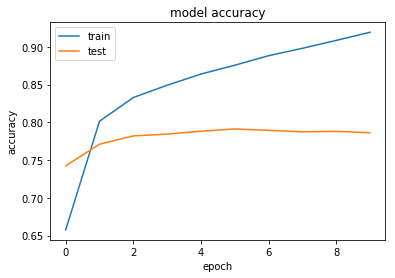

In [132]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

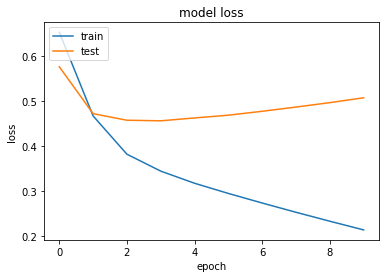

In [133]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Second MLP Attempt
Let's try increasing the length of the inputs and adding early stopping once the validation scores stop improving

In [134]:
maxlen=50
x_train = preprocessing.sequence.pad_sequences(train_sequences, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(test_sequences, maxlen=maxlen)

model = Sequential()
# We specify the maximum input length to our Embedding layer
# so we can later flatten the embedded inputs
model.add(Embedding(10000, 8, input_length=maxlen))

model.add(Flatten())

# We add the classifier on top
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, train_labels,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2, 
                    callbacks=[EarlyStopping()])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 8)             80000     
_________________________________________________________________
flatten_3 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 401       
Total params: 80,401
Trainable params: 80,401
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/50
20000/20000 [==============================] - 2s 82us/step - loss: 0.5841 - acc: 0.7346 - val_loss: 0.4383 - val_acc: 0.8144
Epoch 2/50
20000/20000 [==============================] - 1s 47us/step - loss: 0.3360 - acc: 0.8642 - val_loss: 0.3645 - val_acc: 0.8374
Epoch 3/50
20000/20000 [==============================] - 1s 48us/step - loss: 

In [135]:
score = model.evaluate(x_test, test_labels, verbose=1)

25000/25000 [==============================] - 1s 48us/step


In [136]:
print('Test Loss:', score[0], 'Test Accuracy:', score[1])

Test Loss: 0.33549573088645934 Test Accuracy: 0.85348


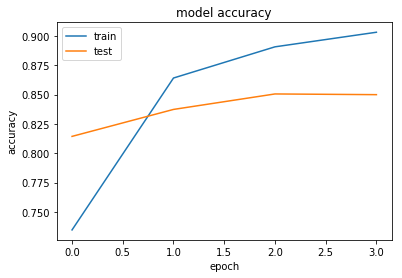

In [137]:

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

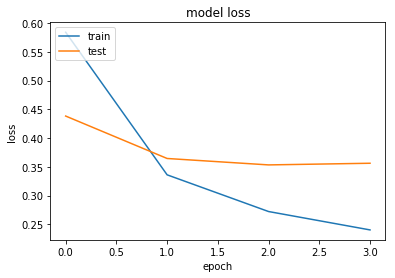

In [138]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Third MLP Attempt
That brought some improvement. Let's try increasing the length of the inputs again.

In [140]:
maxlen=100
x_train = preprocessing.sequence.pad_sequences(train_sequences, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(test_sequences, maxlen=maxlen)

model = Sequential()

model.add(Embedding(10000, 8, input_length=maxlen))

model.add(Flatten())

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, train_labels,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2, 
                    callbacks=[EarlyStopping()])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 8)            80000     
_________________________________________________________________
flatten_4 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 801       
Total params: 80,801
Trainable params: 80,801
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/50
20000/20000 [==============================] - 2s 97us/step - loss: 0.6233 - acc: 0.6762 - val_loss: 0.4433 - val_acc: 0.8318
Epoch 2/50
20000/20000 [==============================] - 2s 114us/step - loss: 0.3125 - acc: 0.8826 - val_loss: 0.3129 - val_acc: 0.8660
Epoch 3/50
20000/20000 [==============================] - 3s 126us/step - loss

In [141]:
score = model.evaluate(x_test, test_labels, verbose=1)
print('Test Loss:', score[0], 'Test Accuracy:', score[1])

25000/25000 [==============================] - 1s 21us/step
Test Loss: 0.2862664505672455 Test Accuracy: 0.87932


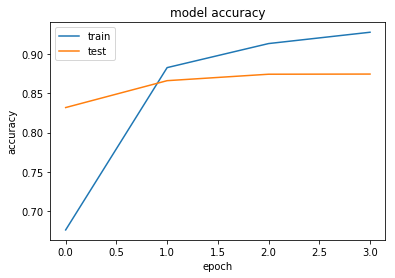

In [142]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

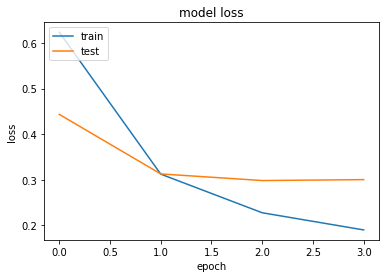

In [143]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Test on EDGAR data

In [60]:
edgar_data = pd.read_json('merged_transcripts.json')

In [61]:
edgar_data.head()

,Sentiment,Text
0,Neutral,Could you catch us up on your latest thinking ...
1,Neutral,We continue to ramp up the activities for the ...
10,Neutral,"I think, we're …"
100,Neutral,"Greg, I wonder if I just get a couple of clari..."
1000,Negative,"First, we successfully increased our wallet sh..."


In [62]:
edgar_data.shape

(1649, 2)

In [65]:
edgar_data['Sentiment'].value_counts(dropna=False)

neutral       529
positive      504
Neutral       289
Positive      121
negative      116
Negative       37
 positive      17
postive        12
 neutral        9
NaN             6
Neural          3
Negetive        2
 negative       2
 neutral        1
neutra;         1
Name: Sentiment, dtype: int64

In [66]:
edgar_data.replace('Neutral', 'neutral', inplace=True)
edgar_data.replace(' neutral', 'neutral', inplace=True)
edgar_data.replace(' neutral ', 'neutral', inplace=True)
edgar_data.replace('neutra;', 'neutral', inplace=True)
edgar_data.replace('Neural', 'neutral', inplace=True)
edgar_data.replace('None', 'neutral', inplace=True)
edgar_data.replace('Negative', 'negative', inplace=True)
edgar_data.replace('Negetive', 'negative', inplace=True)
edgar_data.replace(' negative', 'negative', inplace=True)
edgar_data.replace('Positive', 'positive', inplace=True)
edgar_data.replace(' positive', 'positive', inplace=True)
edgar_data.replace(' positive ', 'positive', inplace=True)
edgar_data.replace('postive', 'positive', inplace=True)
edgar_data.fillna('neutral', inplace=True)

In [67]:
edgar_data['Sentiment'].value_counts()

neutral     838
positive    654
negative    157
Name: Sentiment, dtype: int64

In [69]:
edgar_data.to_csv('cleaned_merged_data.csv', index=False)

In [72]:
edgar_test = edgar_data[edgar_data['Sentiment'] != 'neutral']

In [73]:
edgar_test.head()

,Sentiment,Text
1000,negative,"First, we successfully increased our wallet sh..."
1001,positive,"Second, we remained focused on leveraging our ..."
1002,positive,"Lastly, we remained focused on continued inves..."
1003,positive,"Moving to Page 8. In Equities, as it relates t..."
1004,positive,"For 2018, Equities produced net revenues of $7..."


In [74]:
edgar_test.shape

(811, 2)

In [77]:
edgar_test['Sentiment'] = edgar_test['Sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [78]:
edgar_test['Sentiment'].value_counts()

1    654
0    157
Name: Sentiment, dtype: int64

In [79]:
edgar_test_labels = np.asarray(edgar_test['Sentiment'])

In [153]:
edgar_x_test = edgar_test['Text'].tolist()

edgar_x_sequences = tokenizer.texts_to_sequences(edgar_x_test)

In [154]:
edgar_x_sequences = preprocessing.sequence.pad_sequences(edgar_x_sequences, maxlen=maxlen)

In [155]:
predictions = model.predict(edgar_x_sequences, verbose=1)

811/811 [==============================] - 0s 70us/step


In [157]:
scores = model.evaluate(edgar_x_sequences, edgar_test_labels, verbose=1)

811/811 [==============================] - 0s 41us/step


In [159]:
print('Test Loss:', scores[0], 'Test Accuracy:', scores[1])

Test Loss: 0.8774671805919172 Test Accuracy: 0.5277435266574714


In [166]:
cfm = confusion_matrix(edgar_test_labels, np.rint(predictions))

In [167]:
cfm

array([[ 99,  58],
       [325, 329]])

# Bag of Words

In [150]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_data)
x_train = tokenizer.texts_to_matrix(train_data, mode='freq')
x_test = tokenizer.texts_to_matrix(test_data, mode='freq')

In [151]:
n_words = x_train.shape[1]

model = Sequential()

model.add(Dense(50, input_shape=(n_words,), activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, train_labels,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2, 
                    callbacks=[EarlyStopping()])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 50)                500050    
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 51        
Total params: 500,101
Trainable params: 500,101
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/50
20000/20000 [==============================] - 7s 345us/step - loss: 0.5988 - acc: 0.8141 - val_loss: 0.4796 - val_acc: 0.8526
Epoch 2/50
20000/20000 [==============================] - 6s 312us/step - loss: 0.3841 - acc: 0.8715 - val_loss: 0.3372 - val_acc: 0.8732
Epoch 3/50
20000/20000 [==============================] - 6s 285us/step - loss: 0.2889 - acc: 0.8922 - val_loss: 0.2948 - val_acc: 0.8806
Epoch 4/50
20000/20000 [==============================] - 6s 296us/st

In [152]:
score = model.evaluate(x_test, test_labels, verbose=1)
print('Test Loss:', score[0], 'Test Accuracy:', score[1])

25000/25000 [==============================] - 4s 162us/step
Test Loss: 0.27487772597789767 Test Accuracy: 0.88864


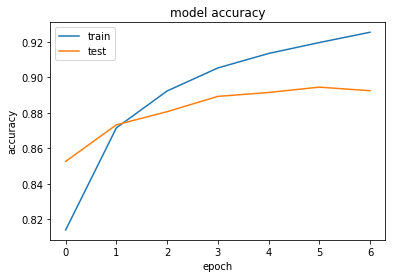

In [153]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

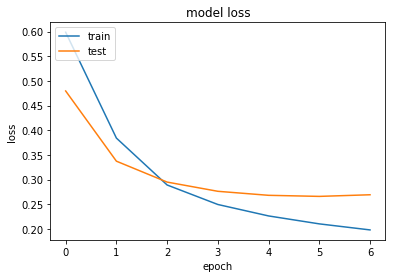

In [154]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Test on EDGAR Data

In [155]:
edgar_data = pd.read_csv('cleaned_merged_data.csv')
edgar_test = edgar_data[edgar_data['Sentiment'] != 'neutral']
edgar_test['Sentiment'] = edgar_test['Sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [156]:
edgar_x_test_bow = tokenizer.texts_to_matrix(edgar_test['Text'].tolist(), mode='freq')
edgar_test_labels = np.asarray(edgar_test['Sentiment'])

In [157]:
score = model.evaluate(edgar_x_test_bow, edgar_test_labels, verbose=1)
print('Test Loss:', score[0], 'Test Accuracy:', score[1])

811/811 [==============================] - 0s 45us/step
Test Loss: 0.7450068825270186 Test Accuracy: 0.6535141799511657


In [158]:
predictions = model.predict(edgar_x_test_bow, verbose=1)

811/811 [==============================] - 0s 568us/step


In [159]:
cfm = confusion_matrix(edgar_test_labels, np.rint(predictions))
cfm

array([[ 69,  88],
       [193, 461]])

In [160]:
model.save('bow_model.h5')

# Bag of Words + TF-IDF

In [8]:
# Reference: https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(train_data)
X_train_counts.shape

(25000, 74848)

In [9]:
count_vect.vocabulary_.get(u'algorithm')

2611

In [16]:
from sklearn.feature_extraction.text import TfidfTransformer

tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
X_train_tf.shape

(25000, 74848)

In [48]:
X_test_counts = count_vect.transform(test_data)
X_test_tf = tf_transformer.transform(X_test_counts)

In [21]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train_tf.toarray(), train_labels)

GaussianNB(priors=None, var_smoothing=1e-09)

In [49]:
X_test_tf = X_test_tf.toarray()
predictions0 = gnb.predict(X_test_tf[:1000])
predictions1 = gnb.predict(X_test_tf[1000:5000])
predictions2 = gnb.predict(X_test_tf[5000:10000])
predictions3 = gnb.predict(X_test_tf[10000:15000])
predictions4 = gnb.predict(X_test_tf[15000:20000])
predictions5 = gnb.predict(X_test_tf[20000:])
predictions = np.concatenate((predictions0, predictions1, predictions2, predictions3, predictions4, predictions5))

In [50]:
accuracy_score(test_labels, predictions)

0.572

In [51]:
cfm = confusion_matrix(test_labels, predictions)
cfm

array([[8716, 3784],
       [6916, 5584]])

## Test on EDGAR Data

In [45]:
edgar_X_test_counts = count_vect.transform(edgar_test['Text'].tolist())
edgar_X_test_tf = tf_transformer.transform(edgar_X_test_counts)

In [52]:
predictions = gnb.predict(edgar_X_test_tf.toarray())
cfm = confusion_matrix(edgar_test_labels, predictions)
cfm

array([[ 93,  64],
       [388, 266]])

In [53]:
accuracy_score(edgar_test_labels, predictions)

0.44266337854500615

# GLOVE Embeddings

In [161]:
maxlen = 100  # We will cut reviews after 100 words
max_words = 10000  # We will only consider the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_data)
train_sequences = tokenizer.texts_to_sequences(train_data)
test_sequences = tokenizer.texts_to_sequences(test_data)

word_index = tokenizer.word_index
print('Found {} unique tokens'.format(len(word_index)))

Found 88065 unique tokens


In [162]:
x_train = preprocessing.sequence.pad_sequences(train_sequences, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(test_sequences, maxlen=maxlen)

In [163]:
glove_dir = 'glove6B'

embeddings_index = {}
f = open(os.path.join(os.getcwd(), glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))


Found 400000 word vectors.


In [164]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

In [114]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_7 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [115]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [116]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, train_labels,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_test, test_labels),
                    callbacks=[EarlyStopping(patience=1)])
model.save_weights('pre_trained_glove_model.h5')

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 7s 270us/step - loss: 0.5680 - acc: 0.7094 - val_loss: 0.6585 - val_acc: 0.6674
Epoch 2/10
25000/25000 [==============================] - 7s 291us/step - loss: 0.4405 - acc: 0.7969 - val_loss: 0.5169 - val_acc: 0.7499
Epoch 3/10
25000/25000 [==============================] - 7s 292us/step - loss: 0.3641 - acc: 0.8358 - val_loss: 0.5856 - val_acc: 0.7346


In [117]:
score = model.evaluate(x_test, test_labels, verbose=1)
print('Test Loss:', score[0], 'Test Accuracy:', score[1])

25000/25000 [==============================] - 0s 18us/step
Test Loss: 0.5855996667861938 Test Accuracy: 0.73456


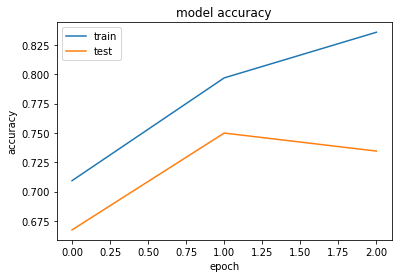

In [118]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

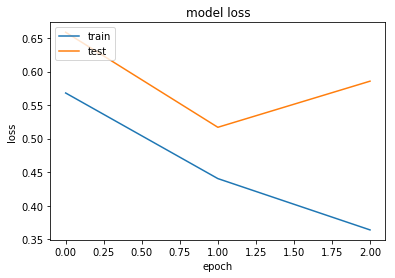

In [119]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Test on EDGAR Data

In [170]:
edgar_x_test = edgar_test['Text'].tolist()
edgar_x_sequences = tokenizer.texts_to_sequences(edgar_x_test)
edgar_x_sequences = preprocessing.sequence.pad_sequences(edgar_x_sequences, maxlen=maxlen)

In [120]:
score = model.evaluate(edgar_x_sequences, edgar_test_labels, verbose=1)
print('Test Loss:', score[0], 'Test Accuracy:', score[1])

811/811 [==============================] - 0s 43us/step
Test Loss: 0.9182979278587972 Test Accuracy: 0.5659679409608006


In [121]:
predictions = model.predict(edgar_x_sequences, verbose=1)

811/811 [==============================] - 0s 119us/step


In [122]:
cfm = confusion_matrix(edgar_test_labels, np.rint(predictions))
cfm

array([[114,  43],
       [309, 345]])

## Tuned GloVe
In the previous attempt the GloVe embedding weights were fixed. This time we will try tuning them.

In [165]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.layers[0].set_weights([embedding_matrix])

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, train_labels,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_test, test_labels),
                    callbacks = [EarlyStopping(patience=1)])

model.save_weights('tuned_glove_model.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_37 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 9s 369us/step - loss: 0.4857 - acc: 0.7597 - val_loss: 0.3679 - val_acc: 0.8352
Epoch 2/10
25000/25000 [==============================] - 9s 356us/step - lo

In [166]:
score = model.evaluate(x_test, test_labels, verbose=1)
print('Test Loss:', score[0], 'Test Accuracy:', score[1])

25000/25000 [==============================] - 2s 85us/step
Test Loss: 0.4001877278637886 Test Accuracy: 0.82456


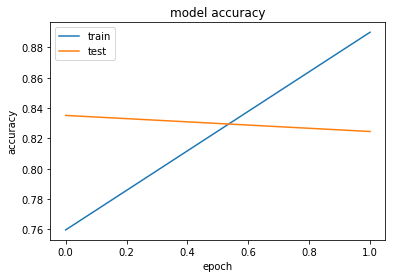

In [167]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

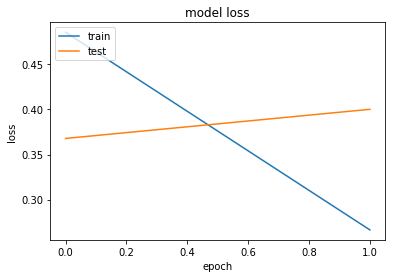

In [168]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Test on EDGAR Data

In [171]:
score = model.evaluate(edgar_x_sequences, edgar_test_labels, verbose=1)
print('Test Loss:', score[0], 'Test Accuracy:', score[1])

811/811 [==============================] - 0s 53us/step
Test Loss: 0.5723951227420944 Test Accuracy: 0.7348951913425572


In [172]:
predictions = model.predict(edgar_x_sequences, verbose=1)

811/811 [==============================] - 0s 563us/step


In [173]:
cfm = confusion_matrix(edgar_test_labels, np.rint(predictions))
cfm

array([[ 51, 106],
       [109, 545]])

In [174]:
model.save('glove_tuned_model.h5')

In [175]:
# Validate the saved model
from keras.models import load_model

glove_model = load_model('glove_tuned_model.h5')

predictions = model.predict(edgar_x_sequences, verbose=1)
cfm = confusion_matrix(edgar_test_labels, np.rint(predictions))
cfm

811/811 [==============================] - 0s 29us/step


array([[ 51, 106],
       [109, 545]])

# RNN

In [10]:
max_words = 10000  # number of words to consider as features
maxlen = 500  # cut texts after this number of words (among top max_features most common words)
batch_size = 32

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_data)
train_sequences = tokenizer.texts_to_sequences(train_data)
test_sequences = tokenizer.texts_to_sequences(test_data)

word_index = tokenizer.word_index
print('Found {} unique tokens'.format(len(word_index)))

input_train = preprocessing.sequence.pad_sequences(train_sequences, maxlen=maxlen)
input_test = preprocessing.sequence.pad_sequences(test_sequences, maxlen=maxlen)

Found 88065 unique tokens


In [19]:
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, train_labels,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2,
                    callbacks=[EarlyStopping()])

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 14s 692us/step - loss: 0.5680 - acc: 0.6912 - val_loss: 0.4652 - val_acc: 0.7882
Epoch 2/10
20000/20000 [==============================] - 14s 681us/step - loss: 0.3225 - acc: 0.8702 - val_loss: 0.3498 - val_acc: 0.8556
Epoch 3/10
20000/20000 [==============================] - 14s 683us/step - loss: 0.2304 - acc: 0.9150 - val_loss: 0.3621 - val_acc: 0.8544


In [20]:
score = model.evaluate(input_test, test_labels, verbose=1)
print('Test Loss:', score[0], 'Test Accuracy:', score[1])

25000/25000 [==============================] - 15s 614us/step
Test Loss: 0.3731996307468414 Test Accuracy: 0.84716


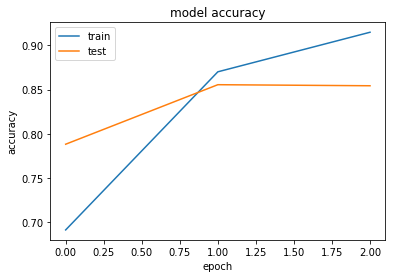

In [21]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

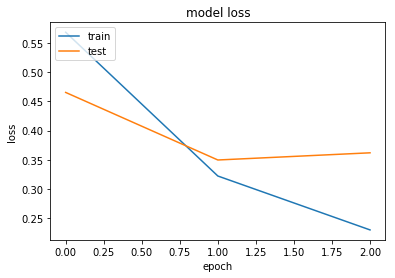

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### RNN Additional RNN Layer

In [31]:
model2 = Sequential()
model2.add(Embedding(max_features, 32))
model2.add(SimpleRNN(32, return_sequences=True))
model2.add(SimpleRNN(32))
model2.add(Dense(1, activation='sigmoid'))

model2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history2 = model2.fit(input_train, train_labels,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2,
                    callbacks=[EarlyStopping()])

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 27s 1ms/step - loss: 0.5790 - acc: 0.6582 - val_loss: 0.4469 - val_acc: 0.7904
Epoch 2/10
20000/20000 [==============================] - 27s 1ms/step - loss: 0.2864 - acc: 0.8859 - val_loss: 0.3231 - val_acc: 0.8636
Epoch 3/10
20000/20000 [==============================] - 27s 1ms/step - loss: 0.1668 - acc: 0.9383 - val_loss: 0.3713 - val_acc: 0.8572


In [32]:
score = model2.evaluate(input_test, test_labels, verbose=1)
print('Test Loss:', score[0], 'Test Accuracy:', score[1])

25000/25000 [==============================] - 24s 968us/step
Test Loss: 0.39415547873973844 Test Accuracy: 0.8518


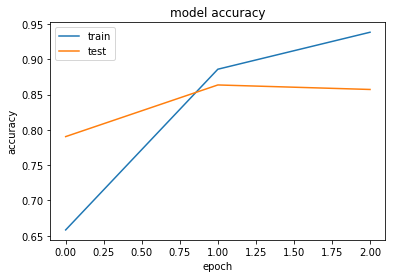

In [37]:
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

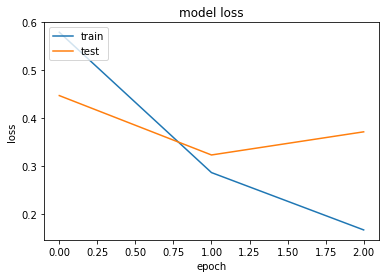

In [38]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### RNN Adam Optimizer

In [35]:
model3 = Sequential()
model3.add(Embedding(max_features, 32))
model3.add(SimpleRNN(32, return_sequences=True))
model3.add(SimpleRNN(32))
model3.add(Dense(1, activation='sigmoid'))

model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history3 = model3.fit(input_train, train_labels,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2,
                    callbacks=[EarlyStopping()])

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 27s 1ms/step - loss: 0.6823 - acc: 0.5469 - val_loss: 0.5836 - val_acc: 0.7016
Epoch 2/10
20000/20000 [==============================] - 27s 1ms/step - loss: 0.3541 - acc: 0.8474 - val_loss: 0.3752 - val_acc: 0.8462
Epoch 3/10
20000/20000 [==============================] - 27s 1ms/step - loss: 0.1059 - acc: 0.9660 - val_loss: 0.4772 - val_acc: 0.8392


In [36]:
score = model3.evaluate(input_test, test_labels, verbose=1)
print('Test Loss:', score[0], 'Test Accuracy:', score[1])

25000/25000 [==============================] - 24s 965us/step
Test Loss: 0.4655215975904465 Test Accuracy: 0.8418


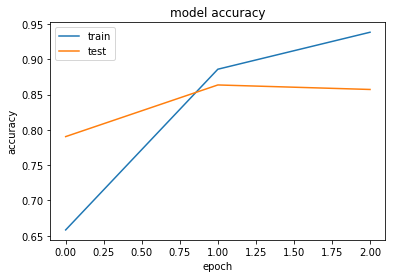

In [39]:
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

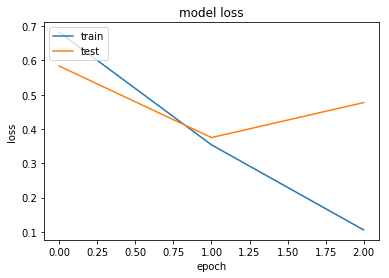

In [40]:
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Test on EDGAR Data
The best RNN model was with a second RNN layer

In [55]:
edgar_data = pd.read_csv('cleaned_merged_data.csv')
edgar_test = edgar_data[edgar_data['Sentiment'] != 'neutral']
edgar_test['Sentiment'] = edgar_test['Sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [58]:
edgar_x_test = tokenizer.texts_to_matrix(edgar_test['Text'].tolist(), mode='freq')
edgar_test_labels = np.asarray(edgar_test['Sentiment'])

In [59]:
score = model2.evaluate(edgar_x_test, edgar_test_labels, verbose=1)
print('Test Loss:', score[0], 'Test Accuracy:', score[1])

811/811 [==============================] - 15s 18ms/step
Test Loss: 0.5475704647903819 Test Accuracy: 0.8064118375319588


In [60]:
predictions = model2.predict(edgar_x_test, verbose=1)
cfm = confusion_matrix(edgar_test_labels, np.rint(predictions))
cfm

811/811 [==============================] - 15s 19ms/step


array([[  0, 157],
       [  0, 654]])

# LSTM

In [44]:
model4 = Sequential()
model4.add(Embedding(max_features, 32))
model4.add(LSTM(32))
model4.add(Dense(1, activation='sigmoid'))

model4.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history4 = model4.fit(input_train, train_labels,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2,
                    callbacks=[EarlyStopping()])

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 66s 3ms/step - loss: 0.4958 - acc: 0.7804 - val_loss: 0.3606 - val_acc: 0.8500
Epoch 2/10
20000/20000 [==============================] - 65s 3ms/step - loss: 0.2819 - acc: 0.8945 - val_loss: 0.2889 - val_acc: 0.8808
Epoch 3/10
20000/20000 [==============================] - 65s 3ms/step - loss: 0.1932 - acc: 0.9297 - val_loss: 0.3938 - val_acc: 0.8726


In [45]:
score = model4.evaluate(input_test, test_labels, verbose=1)
print('Test Loss:', score[0], 'Test Accuracy:', score[1])

25000/25000 [==============================] - 49s 2ms/step
Test Loss: 0.42118600427389147 Test Accuracy: 0.85952


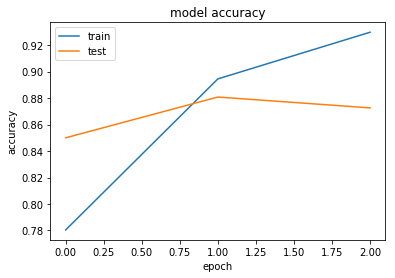

In [46]:
plt.plot(history4.history['acc'])
plt.plot(history4.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

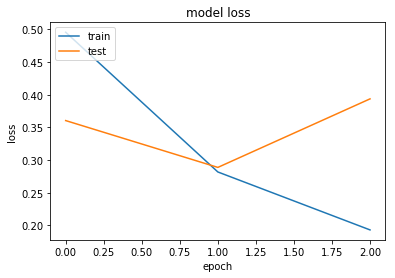

In [47]:
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### LSTM 2nd LSTM Layer

In [51]:
model5 = Sequential()
model5.add(Embedding(max_features, 32))
model5.add(LSTM(32, return_sequences=True))
model5.add(LSTM(32))
model5.add(Dense(1, activation='sigmoid'))

model5.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history5 = model5.fit(input_train, train_labels,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2,
                    callbacks=[EarlyStopping()])

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 131s 7ms/step - loss: 0.4185 - acc: 0.8062 - val_loss: 0.3251 - val_acc: 0.8678
Epoch 2/10
20000/20000 [==============================] - 129s 6ms/step - loss: 0.2373 - acc: 0.9108 - val_loss: 0.3553 - val_acc: 0.8812


In [52]:
score = model5.evaluate(input_test, test_labels, verbose=1)
print('Test Loss:', score[0], 'Test Accuracy:', score[1])

25000/25000 [==============================] - 97s 4ms/step
Test Loss: 0.383004719414711 Test Accuracy: 0.86676


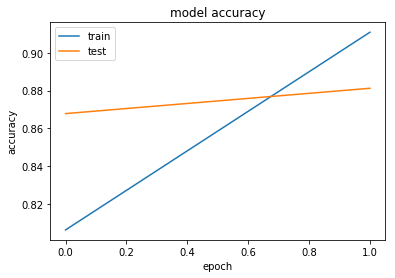

In [53]:
plt.plot(history5.history['acc'])
plt.plot(history5.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

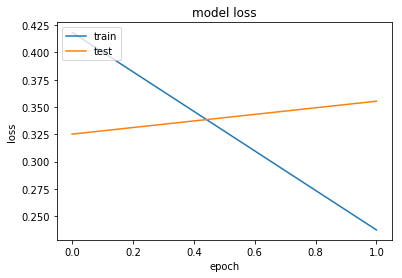

In [54]:
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Test on EDGAR DATA
The best LSTM model was the second one

In [61]:
score = model5.evaluate(edgar_x_test, edgar_test_labels, verbose=1)
print('Test Loss:', score[0], 'Test Accuracy:', score[1])

811/811 [==============================] - 63s 78ms/step
Test Loss: 0.7928598150519055 Test Accuracy: 0.19358816287226507


In [62]:
predictions = model5.predict(edgar_x_test, verbose=1)
cfm = confusion_matrix(edgar_test_labels, np.rint(predictions))
cfm

811/811 [==============================] - 63s 78ms/step


array([[157,   0],
       [654,   0]])